<a href="https://colab.research.google.com/github/ATOMScience-org/AMPL/blob/master/atomsci/ddm/examples/tutorials/07_EDA_With_Harmonization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Install packages** 

In [20]:
# ! pip install rdkit-pypi
# ! pip install numpy==1.24.3
import numpy as np
print(np.__version__)
# ! pip install deepchem

import deepchem as dc
# print(deepchem.__version__)
# ! pip install umap
# ! pip install -U --ignore-installed numba
# ! pip install umap-learn
# ! pip install molvs
# ! pip install bravado

1.24.3


# Load Libraries

In [21]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# manipulate data
import pandas as pd

import json
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib_venn as mpv
from scipy.stats import pearsonr

# set up visualization parameters
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

from matplotlib_venn import venn3
from matplotlib_venn import venn2

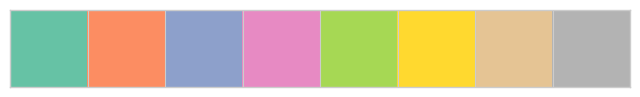

In [22]:
sns.palplot(pal)

In [23]:
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass, os

### Questions to ask while exploring data

- what molecular (and other) identifiers exist for compounds from each database?
- what assay response types are there in each file?
- think about how we might combine these data sources together

Assay data responses questions
- What type of variable are the data responses?
- What kind of ML model would you build to predict this data?
- What kind of visualizations & analysis can you use to understand more about the data?


Why do some columns seem numeric but not give mean, SD? Examine chembl csv file - answer is some 'None' entries

In [5]:
# import sklearn 
# from sklearn.preprocessing import StandardScaler
# def scale_df(data_path): 
#     """Standard Scalar on full dataframe. Pass in full (absolute) datapath"""
#     df=pd.read_csv(data_path)
#     train_df = df[df['fold']!='fold1']
#     test_df = df[df['fold']=='fold1']
#     print(f'train_df shape: {train_df.shape}, test_df shape: {test_df.shape}')

#     label_col = df['active']
#     all_feat_names = df.columns # contains identification compound id and base_rdkit_smiles 
#     all_feat_names = all_feat_names.to_list()
    
#     id_cols = all_feat_names[:2] # ['compound_id', 'base_rdkit_smiles']
    
#     feat_names = all_feat_names[3:] # numerical feat_names
    
#     feat_names = feat_names[:-1] # removing fold 
#     feat_names = all_feat_names[3:-1] 
#     df_numeric = df[feat_names]
#     df_id = df[id_cols]
#     scaler = StandardScaler()
#     df_numeric_scaled = scaler.fit_transform(df_numeric)
    
#     df_numeric_scaled = pd.DataFrame(df_numeric_scaled, columns=feat_names)
    
#     df_scaled = pd.concat([df_id, label_col, df_numeric_scaled, df[['fold']]], axis=1)
#     df_scaled = df_scaled.drop(columns='fold')
#     print(f'shape: {df_scaled.shape}')
#     return(df_scaled)

        

In [24]:
# df = pd.read_csv('/Users/jayceepang/msse/capstone/data/datasets/NEK2_1_uM_min_50_pct_binding_with_moe_descriptors.csv')
# moe = scale_df('/Users/jayceepang/msse/capstone/data/NEK_data_4Berkeley/NEK2/atom_data/NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv')
df = pd.read_csv('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK2/bind/NEK2_binding_moe_scaled_df.csv')

moe.columns
numeric_cols =moe.select_dtypes(include=['number']).columns
tolist =numeric_cols.to_list()
numeric_cols = tolist[1:]


In [25]:
for col in numeric_cols:
  moe[col]=moe[col].astype(float)

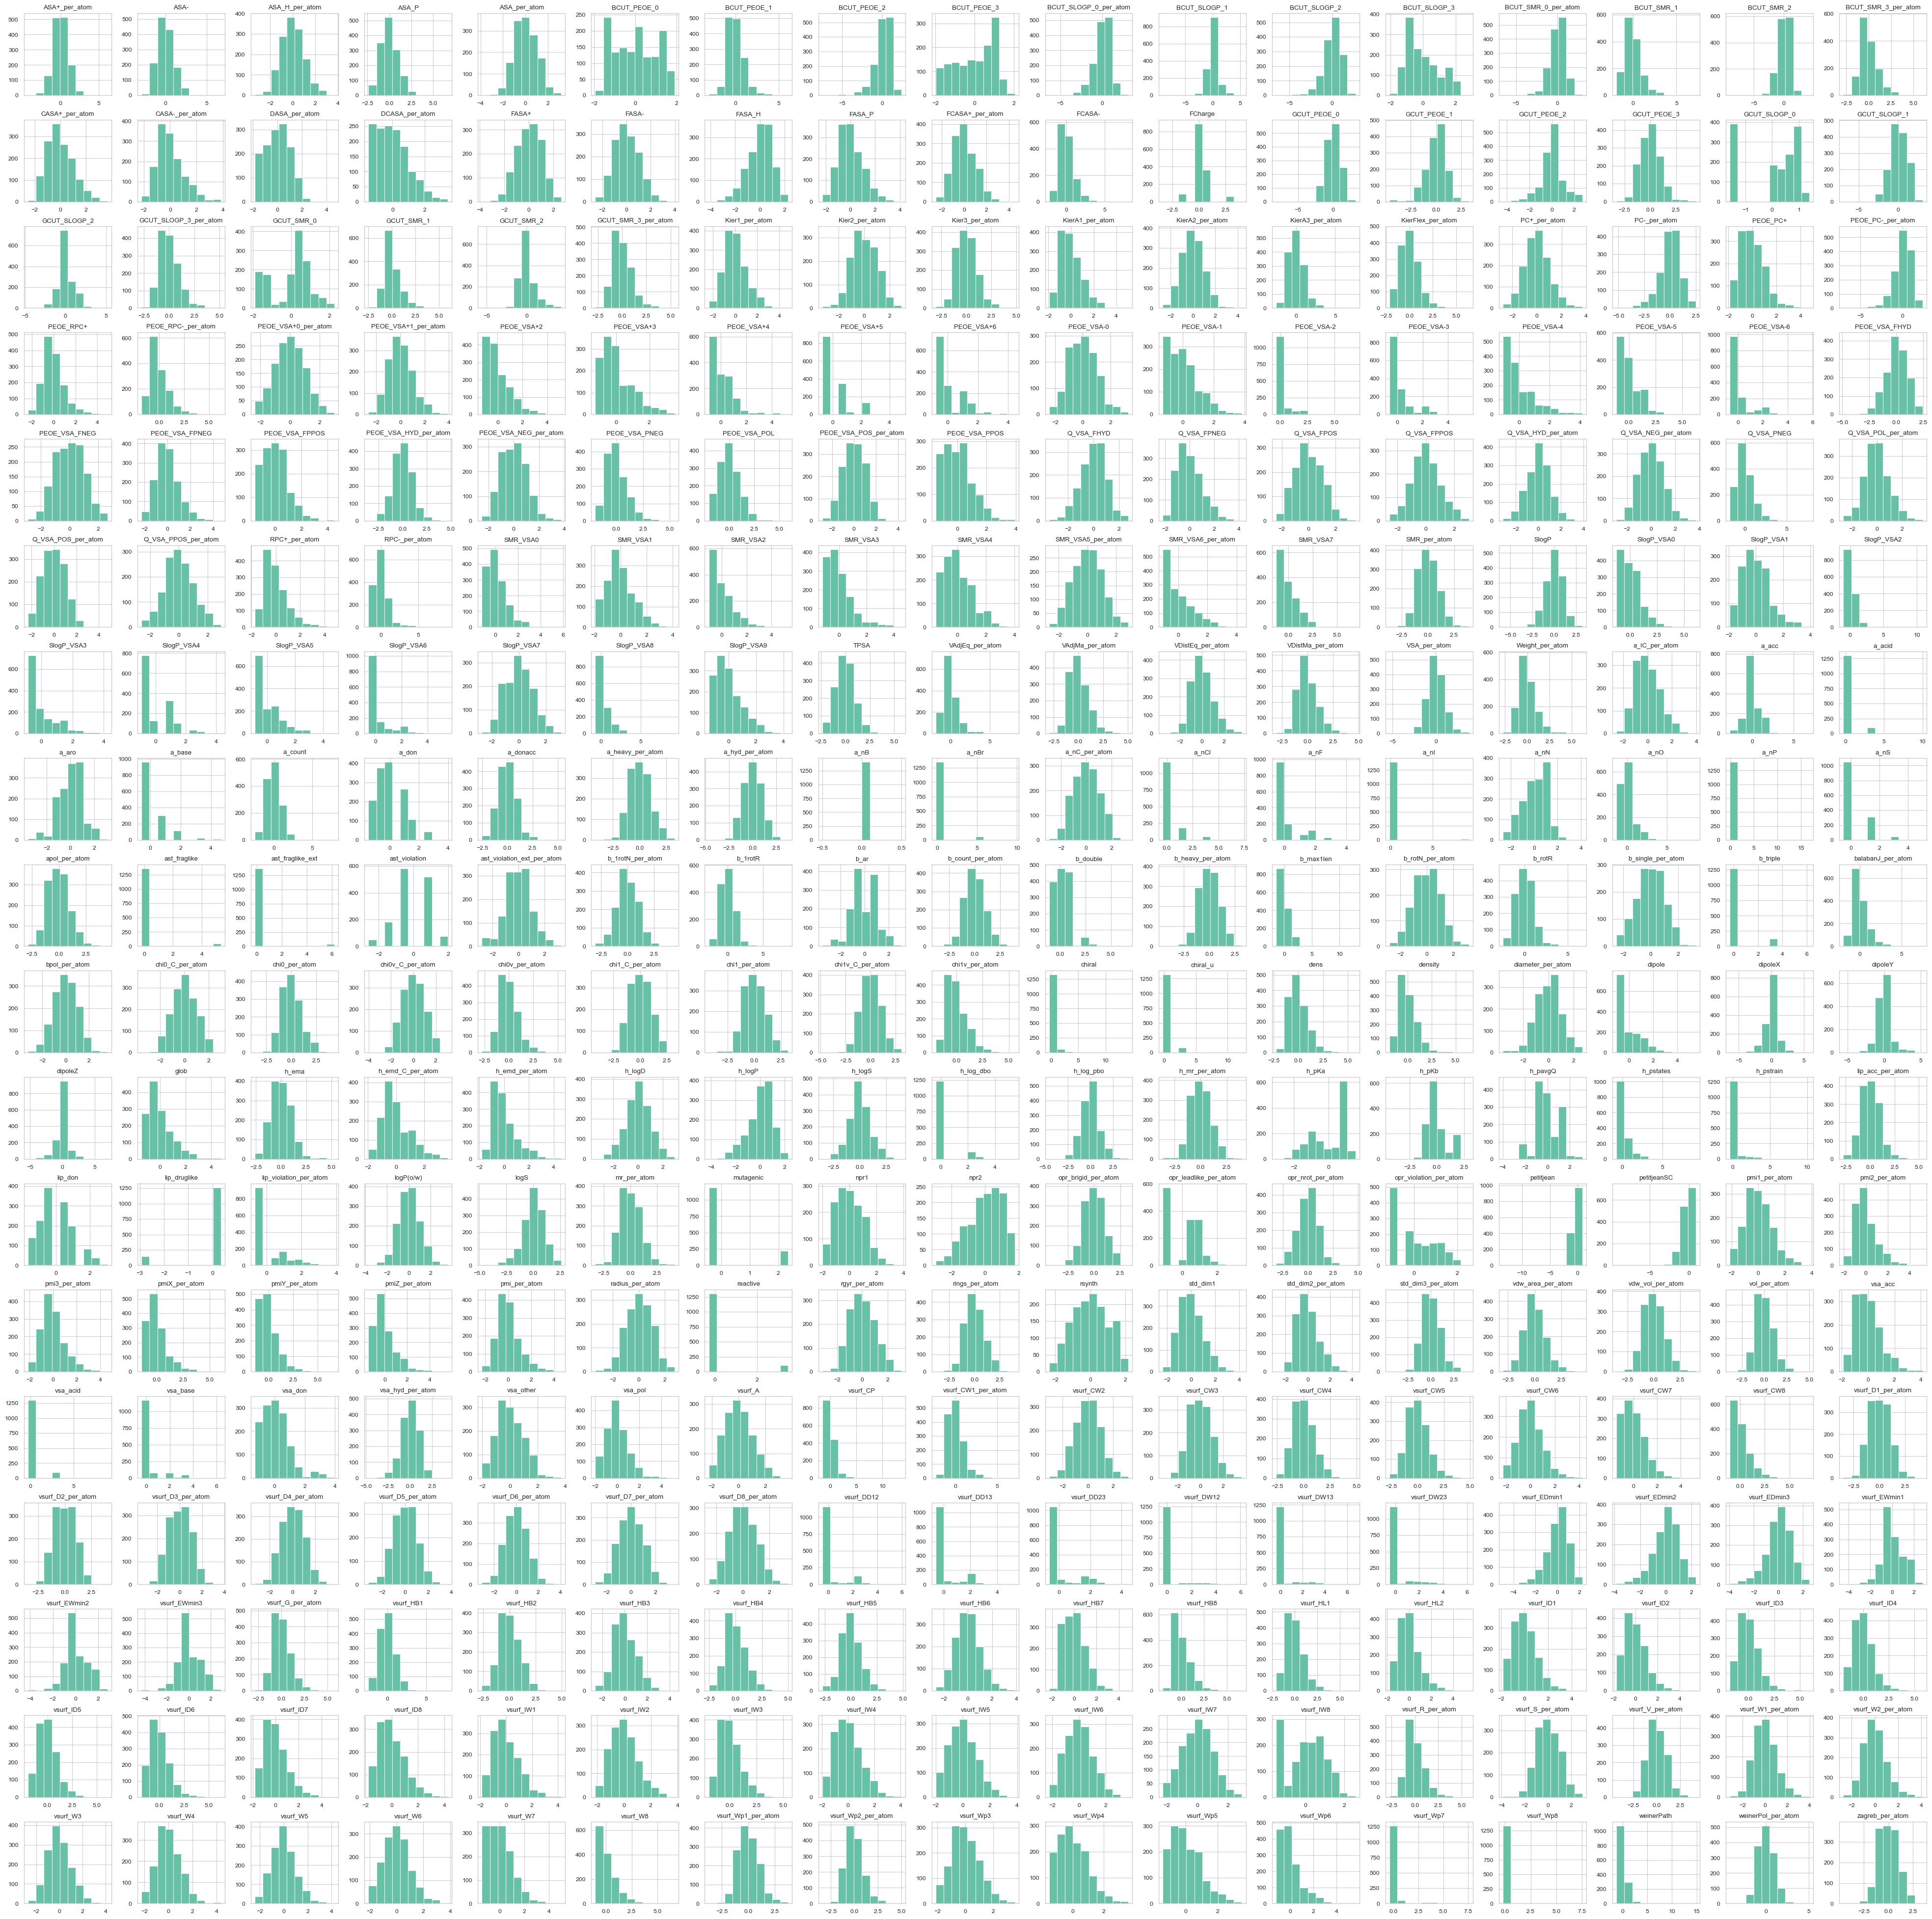

In [26]:
moe[numeric_cols].hist(figsize=(50,50));

In [9]:
# moe.describe()

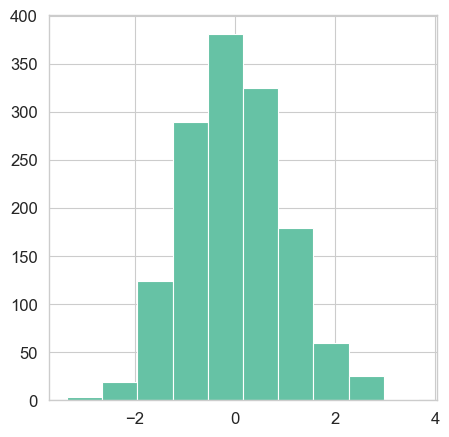

In [19]:
moe['ASA_H_per_atom'].hist(figsize=(5,5));

In [28]:
# df_all = pd.read_csv('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/nek2/features/nek2_moe_bind_scaled_matched.csv')
df_all = pd.read_csv('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK2/bind/NEK2_binding_moe_scaled_df.csv')
df_all

ASA+_per_atom      ASA-  ASA_H_per_atom     ASA_P  ASA_per_atom  \
0          6.171916 -2.880666       -0.242820 -0.138540      3.174018   
1          0.504051  0.725849       -0.489283  1.847024      0.319364   
2         -1.005664  1.857896       -0.732021  1.562579     -0.222465   
3         -0.272463  0.356568       -0.742466  1.119058      0.391476   
4          1.507075 -0.643926        1.305948 -0.705561      1.121426   
...             ...       ...             ...       ...           ...   
1403      -0.829305 -0.606676       -0.711927 -0.580871     -1.457042   
1404       1.325649 -1.222164        2.374258 -1.635889      1.987426   
1405       1.130839 -0.968577        0.678757 -0.691671      0.130626   
1406      -0.073978 -0.955461       -0.432754 -0.659996     -1.040959   
1407       0.181594  0.614570        0.340118  0.210287      0.291354   

      BCUT_PEOE_0  BCUT_PEOE_1  BCUT_PEOE_2  BCUT_PEOE_3  \
0        1.664387     2.956607    -2.776526    -1.873703   
1       -0.163025    -0.395619     0.682256     0.269110   
2       -0.258641     0.555600    -0.776457     0.794523   
3        0.992658    -0.464873     0.315869     0.916609   
4        1.445349     0.459030     1.731704    -1.692399   
...           ...          ...          ...          ...   
1403    -1.209951     1.095581    -0.537771     1.347102   
1404     1.693552    -0.893856     0.765541    -1.947318   
1405     0.118424     0.656058    -1.451143    -0.473444   
1406    -0.678455    -0.542517     0.329226     0.102786   
1407     0.477976    -1.155769     1.108356    -0.130247   

      BCUT_SLOGP_0_per_atom  BCUT_SLOGP_1  BCUT_SLOGP_2  BCUT_SLOGP_3  \
0                 -6.030218      1.700435     -2.768719     -1.855308   
1                 -0.059029     -0.396109      0.672876      0.019380   
2                  0.996309      2.286366     -0.507500      0.993617   
3                  0.039975     -1.066176      0.224961      1.289954   
4                 -0.232629     -0.396109      0.308950     -1.370571   
...                     ...           ...           ...           ...   
1403               0.065689      0.815166     -0.483983      1.238907   
1404              -2.045763     -0.396109      0.931130     -1.209687   
1405               0.291278      0.479987     -0.678717     -0.818751   
1406               0.353850     -0.657452      0.166668     -0.504724   
1407               0.678531     -0.980589      0.778854     -0.138165   

      BCUT_SMR_0_per_atom  BCUT_SMR_1  BCUT_SMR_2  BCUT_SMR_3_per_atom  \
0               -6.278311    3.433815   -1.065802             5.899113   
1                0.670363   -1.001838    0.410427            -0.627921   
2                0.820624    0.886619   -0.683644            -0.751366   
3                0.109246   -0.054003    0.514530             0.624283   
4               -0.311016   -0.327477    0.538129             0.448163   
...                   ...         ...         ...                  ...   
1403             0.467810    0.349740   -1.110692            -0.681813   
1404            -2.903065   -0.879917    0.538129             3.198690   
1405             0.055303    1.431453   -0.883720            -0.290888   
1406             0.198948   -0.580821   -0.025336            -0.363745   
1407             0.612852   -1.152786    1.058686            -0.378948   

      CASA+_per_atom  CASA-_per_atom  DASA_per_atom  DCASA_per_atom     FASA+  \
0          -0.570530       -2.052090       4.613692        0.629003  2.294894   
1           1.428747        0.637223       0.230889        0.814185  0.147888   
2           0.641510        2.222913      -1.176885       -0.824881 -0.885316   
3          -0.435257        0.511502      -0.755313       -0.768865 -0.650176   
4           0.145358       -0.729168       0.784769        0.482150  0.376803   
...              ...             ...            ...             ...       ...   
1403       -0.027529       -0.934137       0.253200        0.449798  0.5203

dist subset
0     0.406250    all
1     0.675676    all
2     0.097222    all
3     0.111111    all
4     0.239130    all
...        ...    ...
1403  0.000000    all
1404  0.425000    all
1405  0.285714    all
1406  0.480000    all
1407  0.228571    all

[1408 rows x 2 columns]

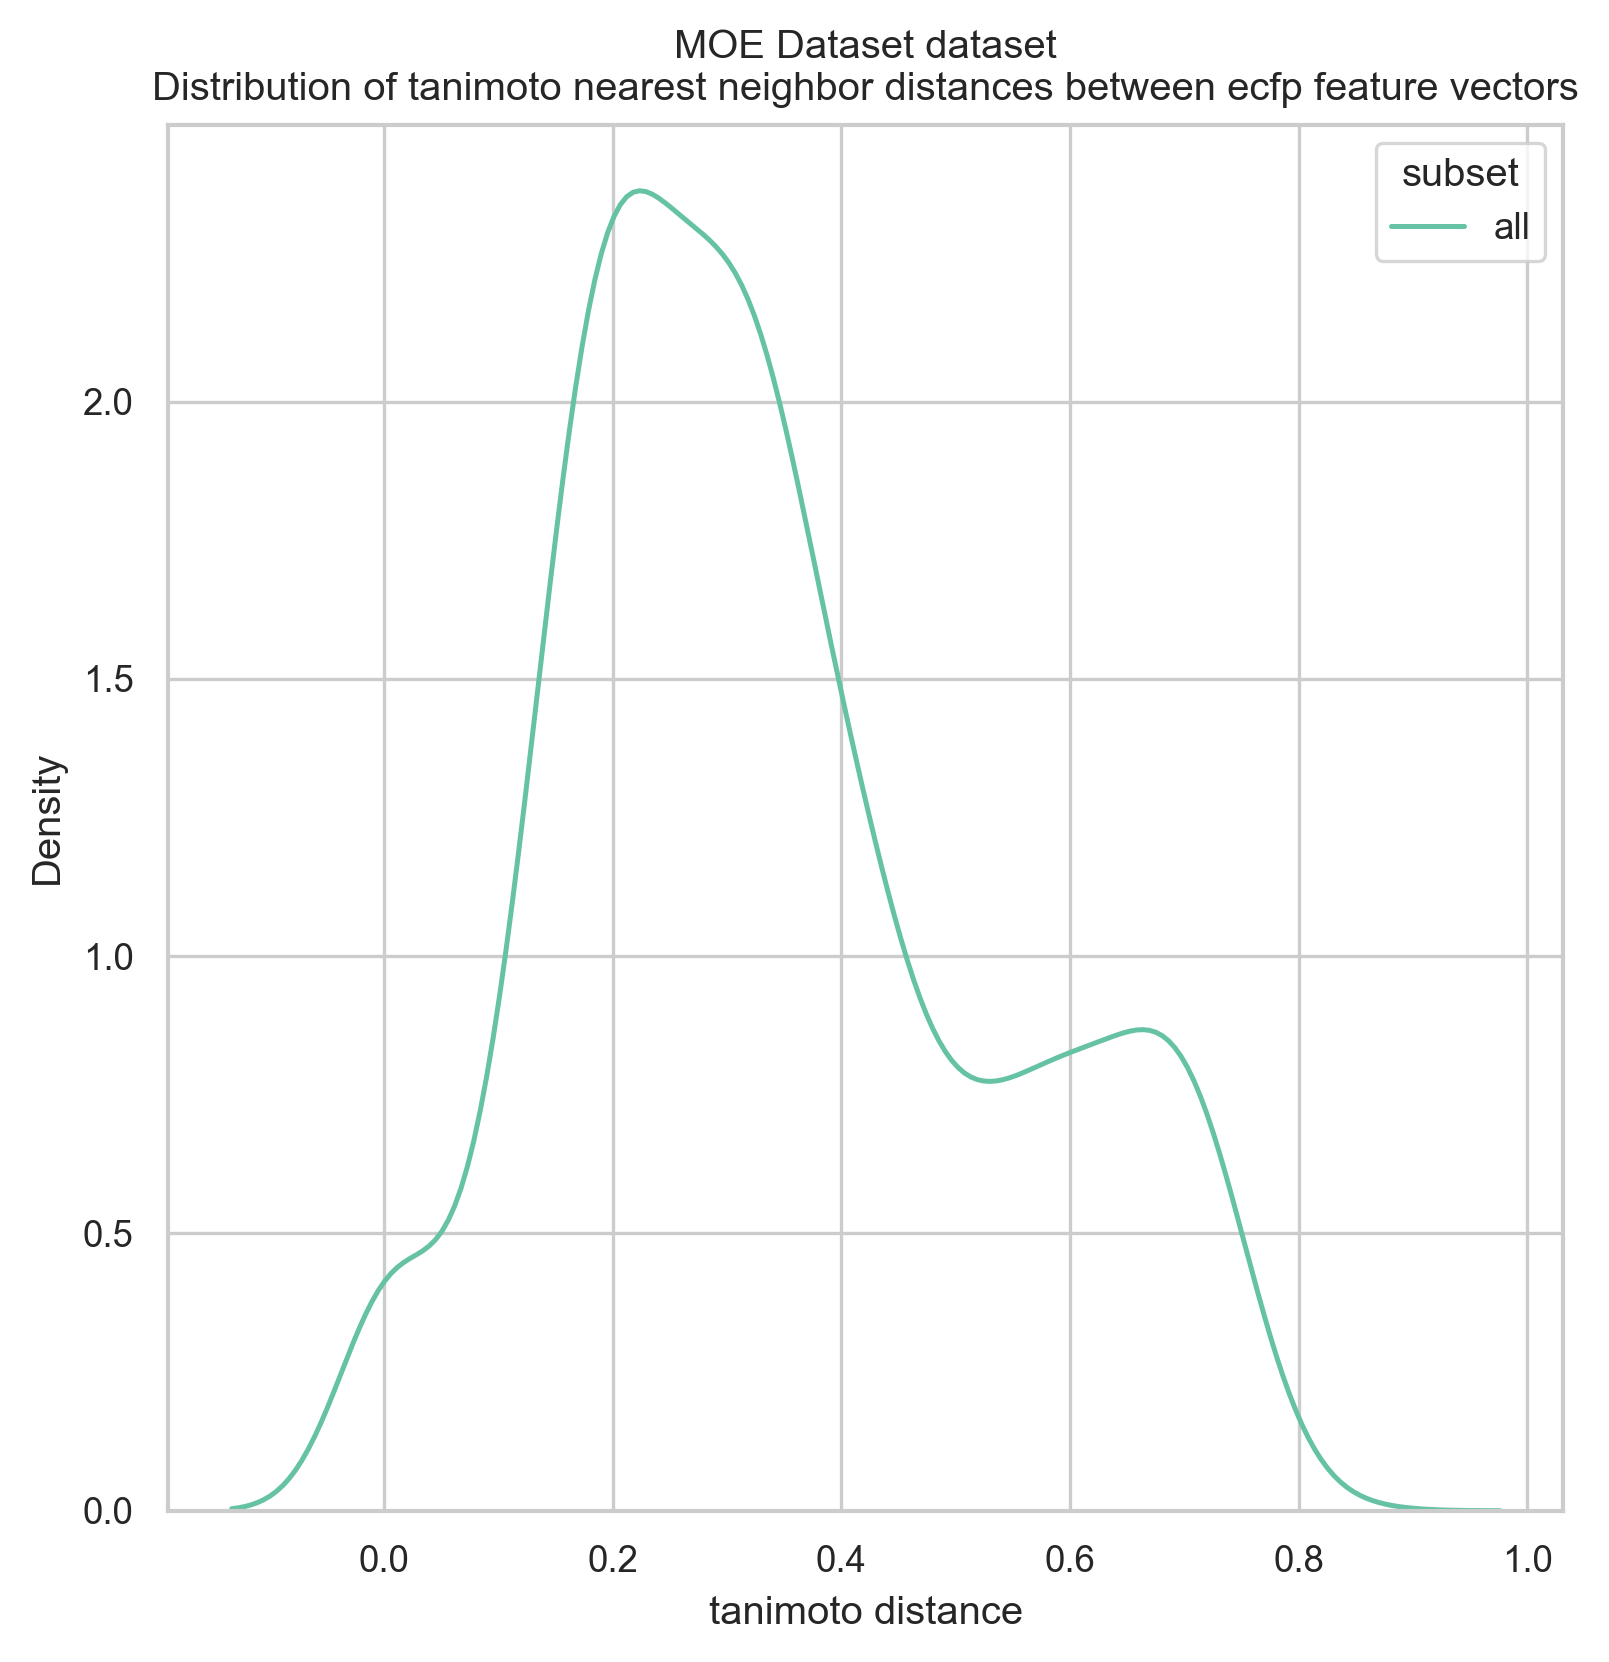

In [29]:
dp.plot_tani_dist_distr(df_all, 'base_rdkit_smiles', 'MOE Dataset')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


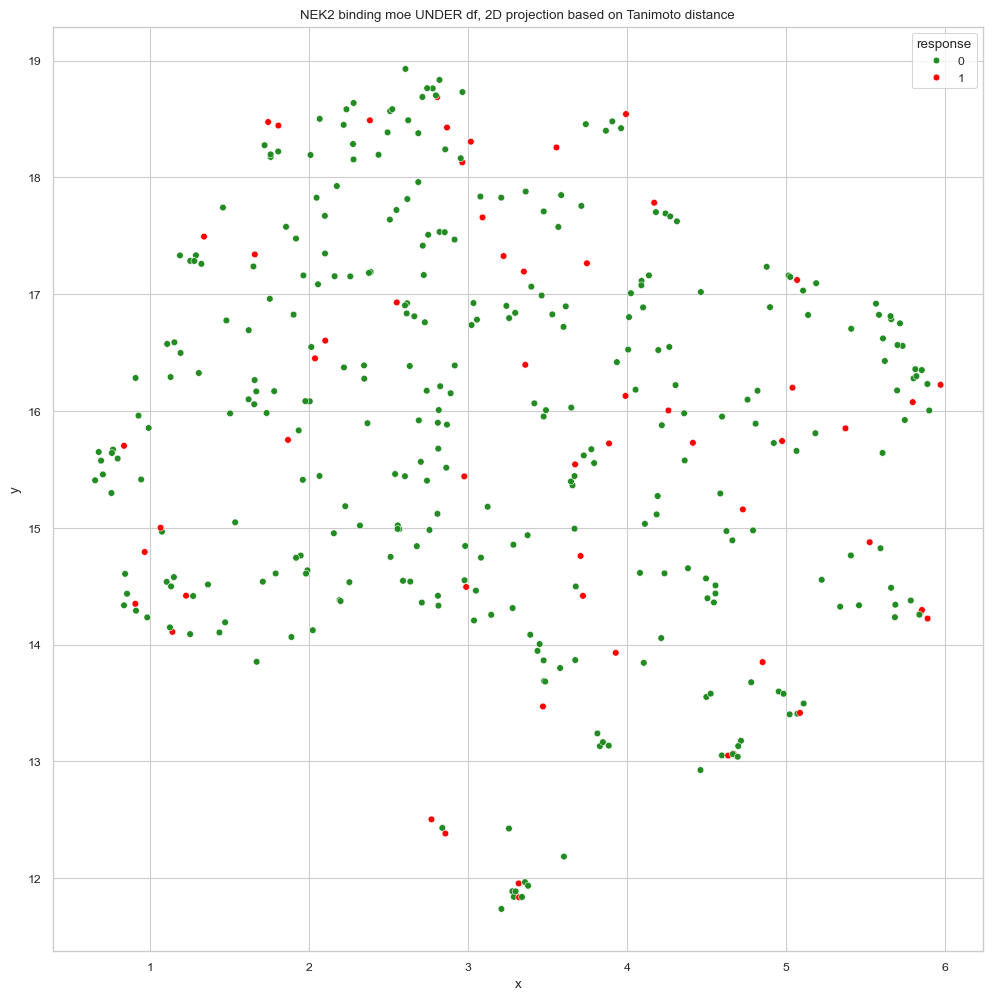

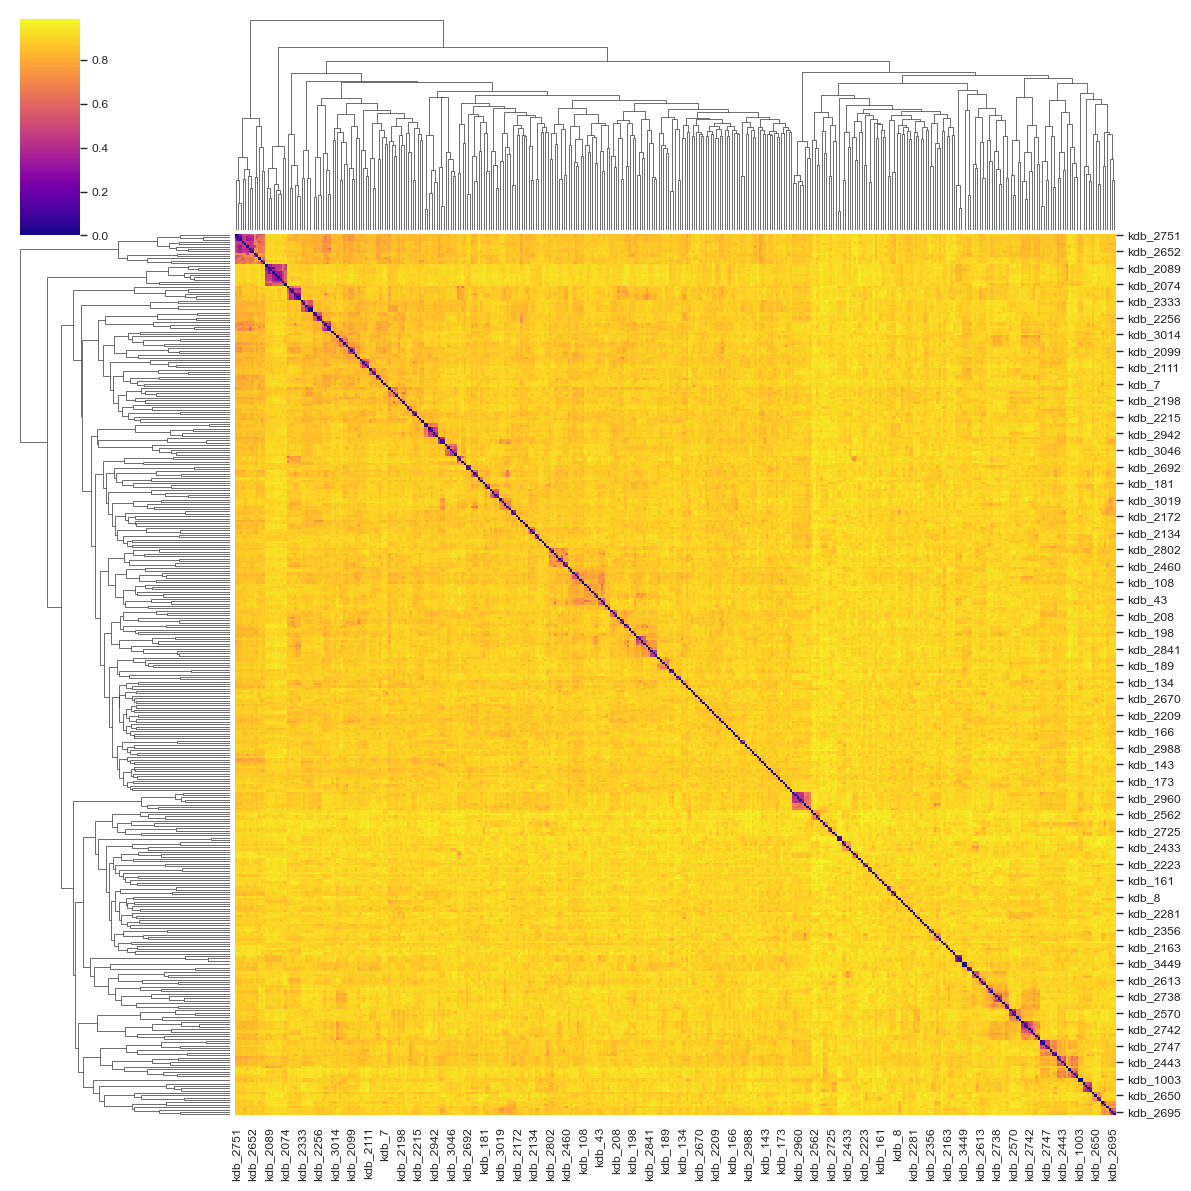

In [31]:
# ! pip install umap-learn

import umap.umap_ as umap
# from umap import UMAPTransformer

    
# dp.diversity_plots(dset_key='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK2/bind/NEK2_binding_moe_scaled_df.csv',
#                    datastore=False, 
#                    id_col ='compound_id', 
#                    smiles_col = 'base_rdkit_smiles', 
#                    is_base_smiles=True, 
#                    response_col = 'active')
dp.diversity_plots(dset_key='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK2/bind/NEK2_binding_moe_UNDER_df.csv',
                   datastore=False, 
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'active')


dist subset
0    0.512821    all
1    0.773810    all
2    0.097222    all
3    0.111111    all
4    0.367347    all
..        ...    ...
368  0.277778    all
369  0.425000    all
370  0.285714    all
371  0.480000    all
372  0.338028    all

[373 rows x 2 columns]

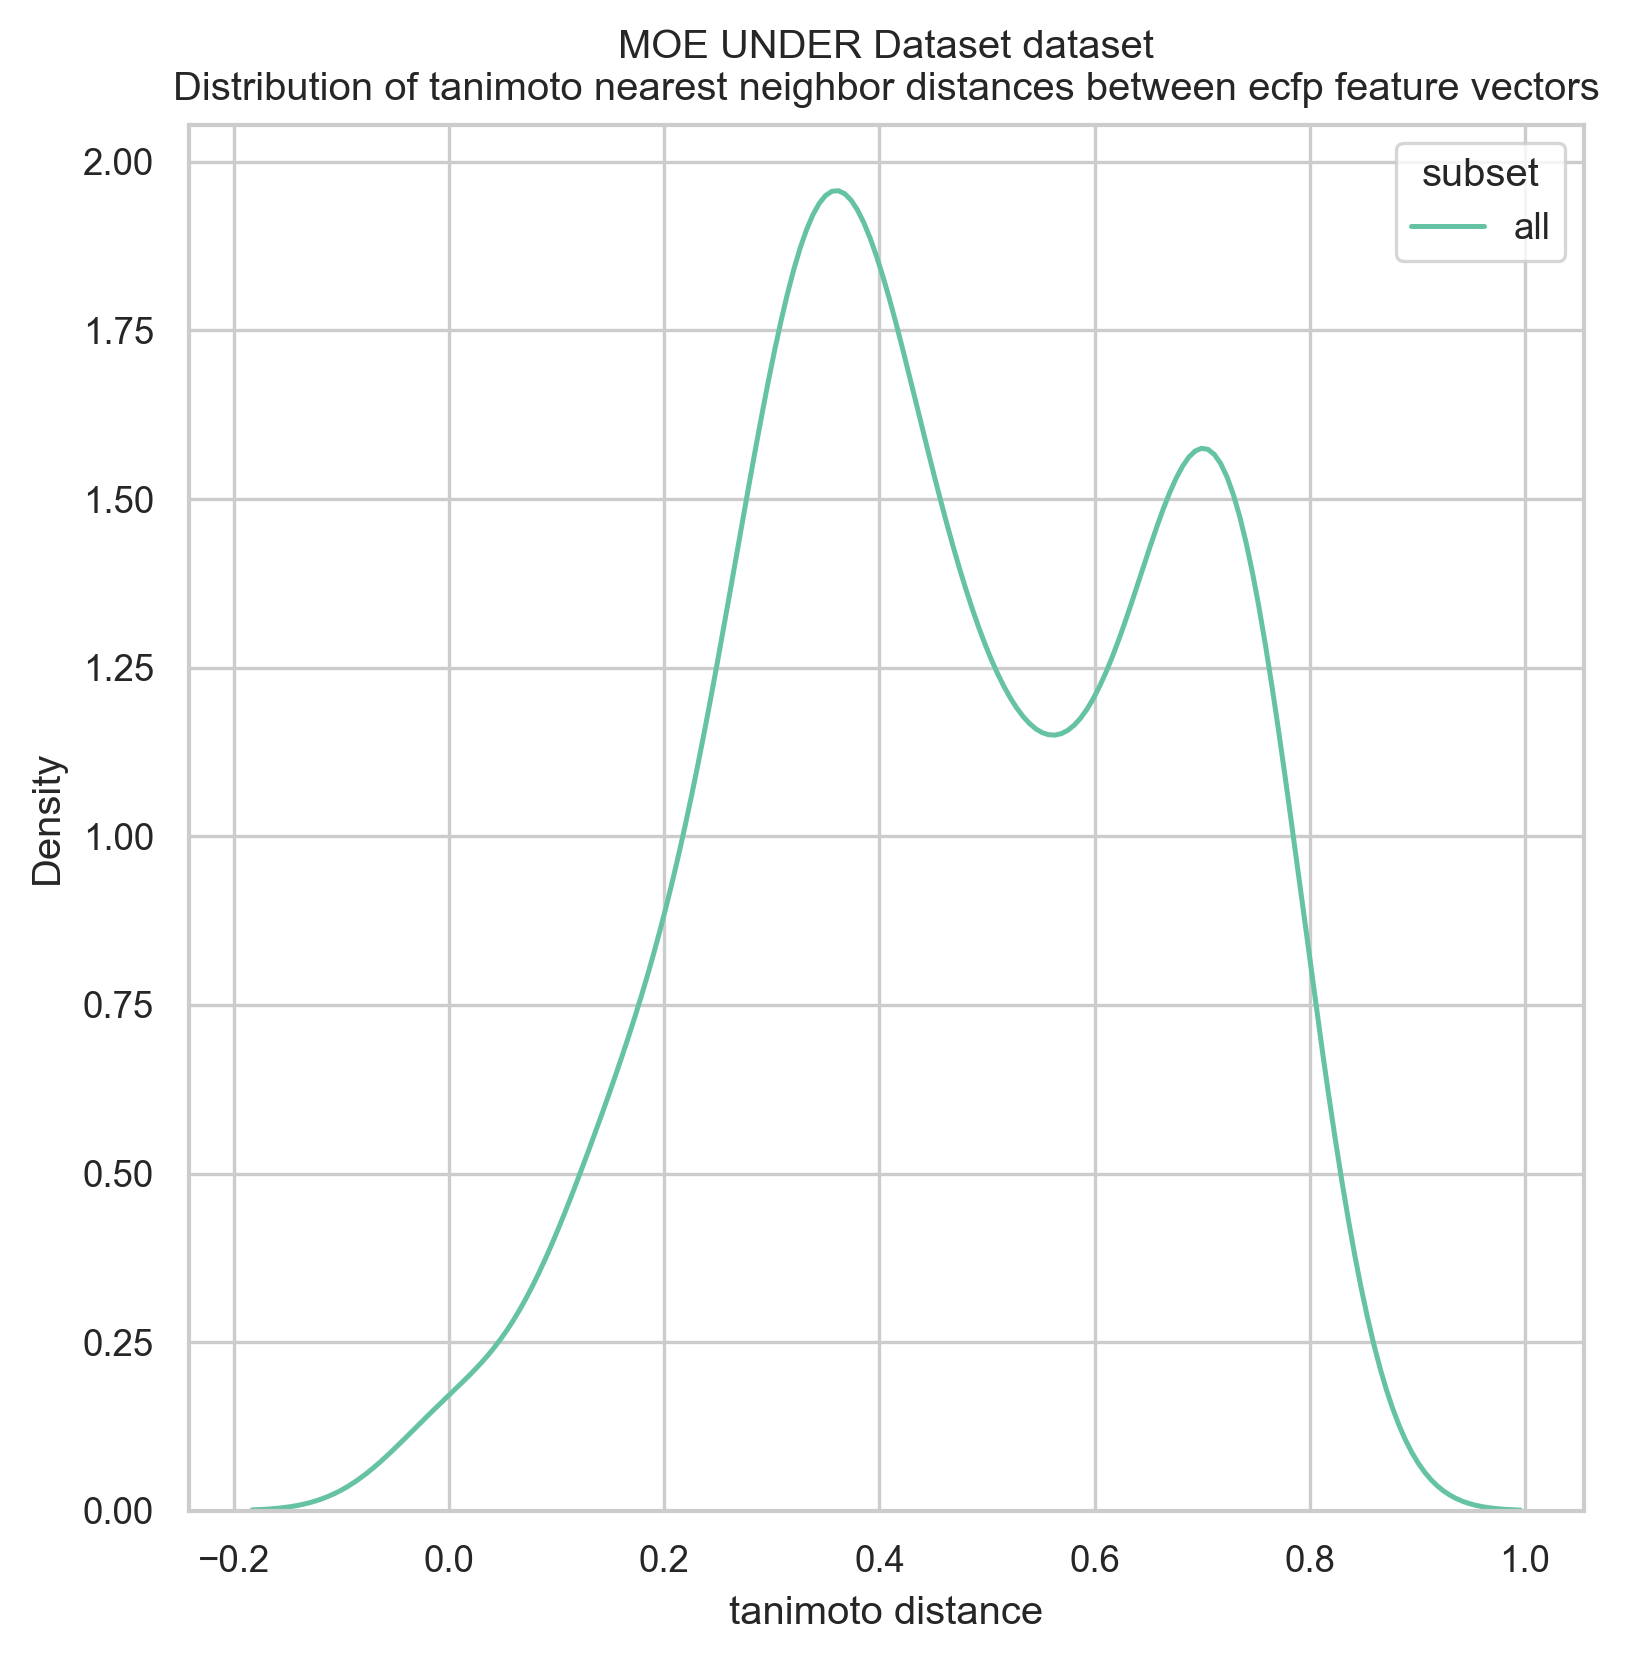

In [32]:
df_UNDER_redo_feats = pd.read_csv('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK2/bind/NEK2_binding_moe_UNDER_df.csv')
dp.plot_tani_dist_distr(df_UNDER_redo_feats, 'base_rdkit_smiles', 'MOE UNDER Dataset')

dist subset
0    0.241935    all
1    0.715789    all
2    0.691176    all
3    0.369565    all
4    0.238095    all
..        ...    ...
368  0.000000    all
369  0.425000    all
370  0.285714    all
371  0.480000    all
372  0.228571    all

[373 rows x 2 columns]

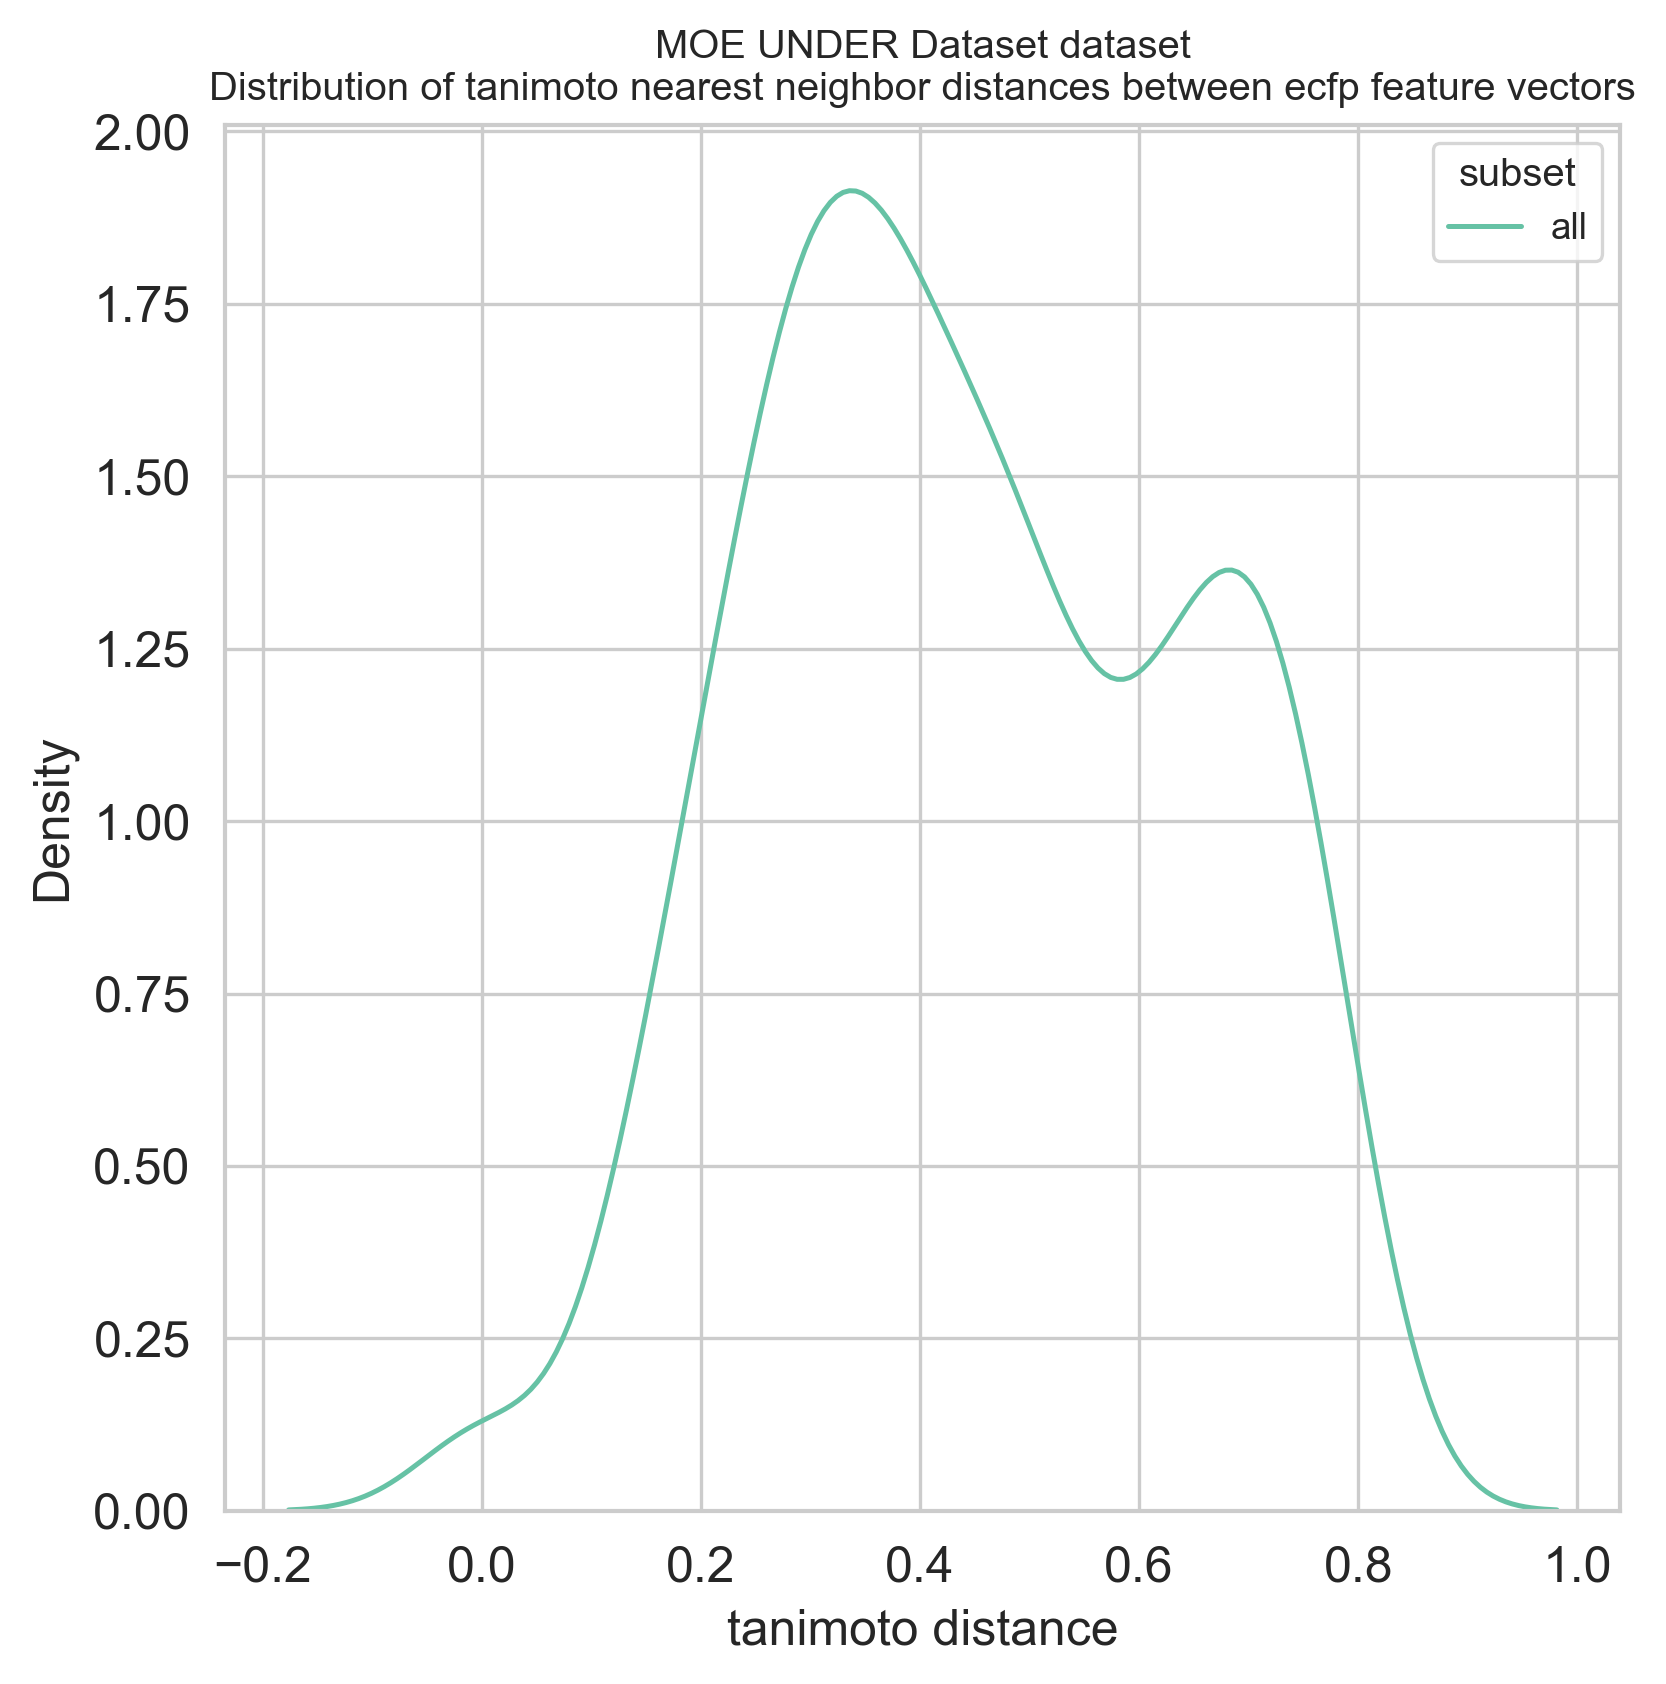

In [11]:
df_UNDER = pd.read_csv('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/nek2/features/nek2_moe_bind_UNDER.csv')
dp.plot_tani_dist_distr(df_UNDER, 'base_rdkit_smiles', 'MOE UNDER Dataset')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


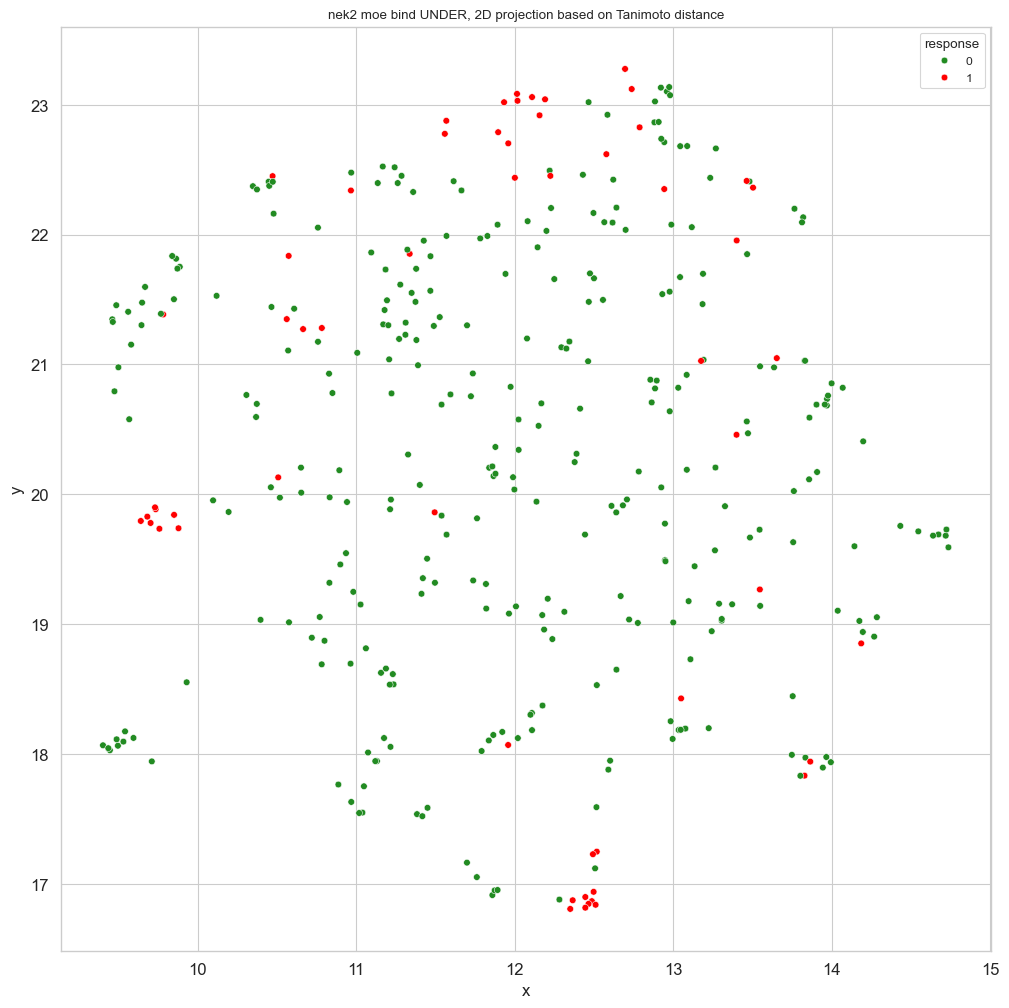

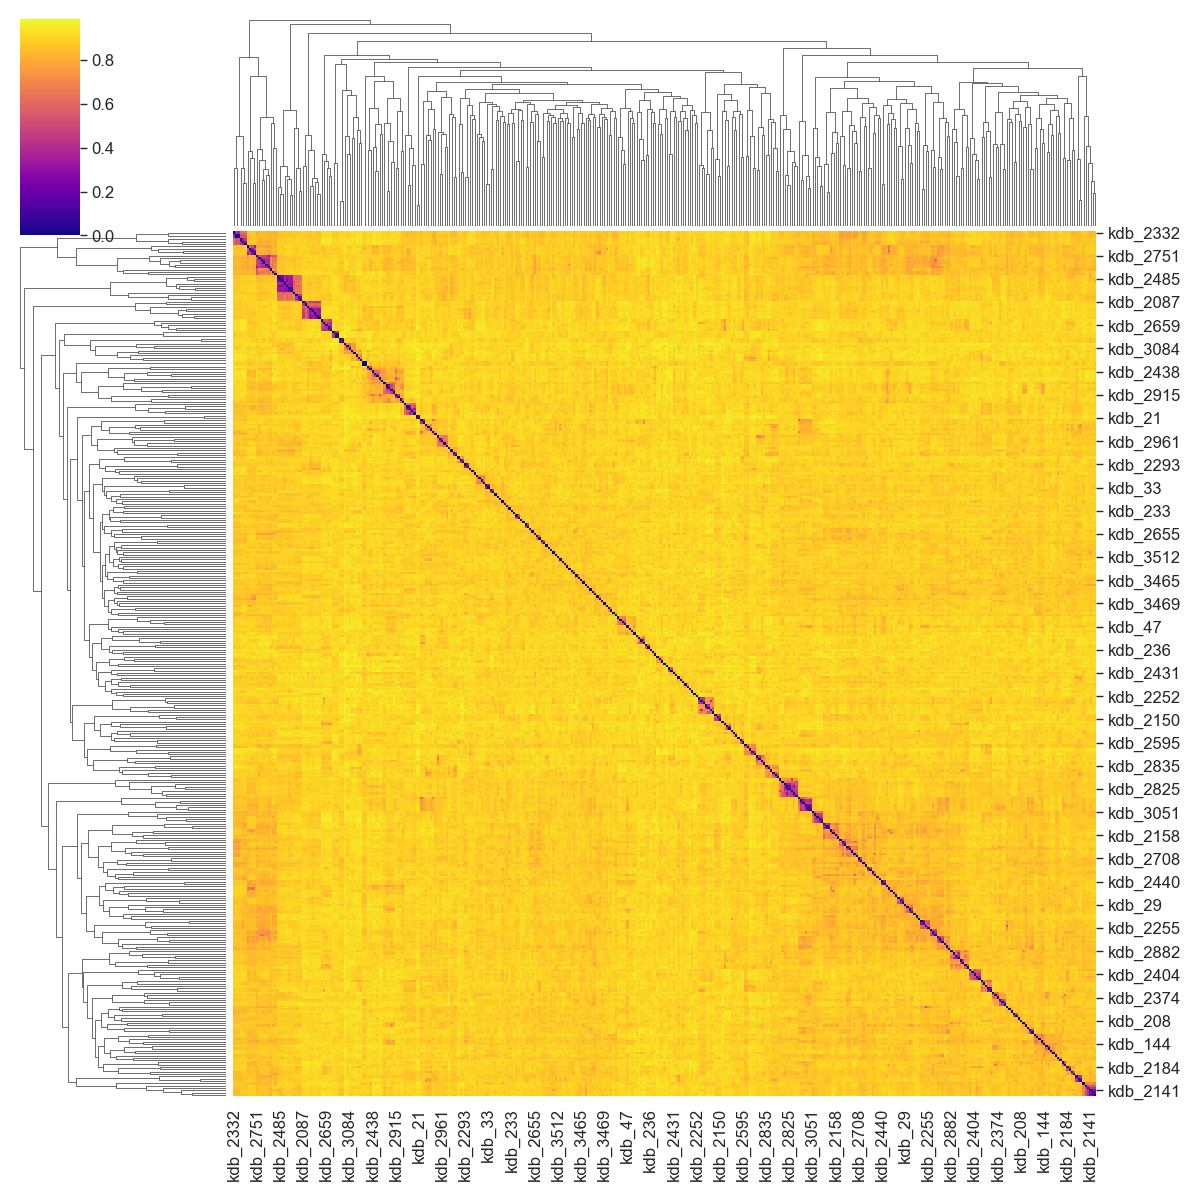

In [12]:
dp.diversity_plots(dset_key='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/nek2/features/nek2_moe_bind_UNDER.csv',
                   datastore=False, 
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'active')


dist subset
0     0.406250    all
1     0.675676    all
2     0.097222    all
3     0.111111    all
4     0.239130    all
...        ...    ...
2438  0.000000    all
2439  0.425000    all
2440  0.285714    all
2441  0.480000    all
2442  0.228571    all

[2443 rows x 2 columns]

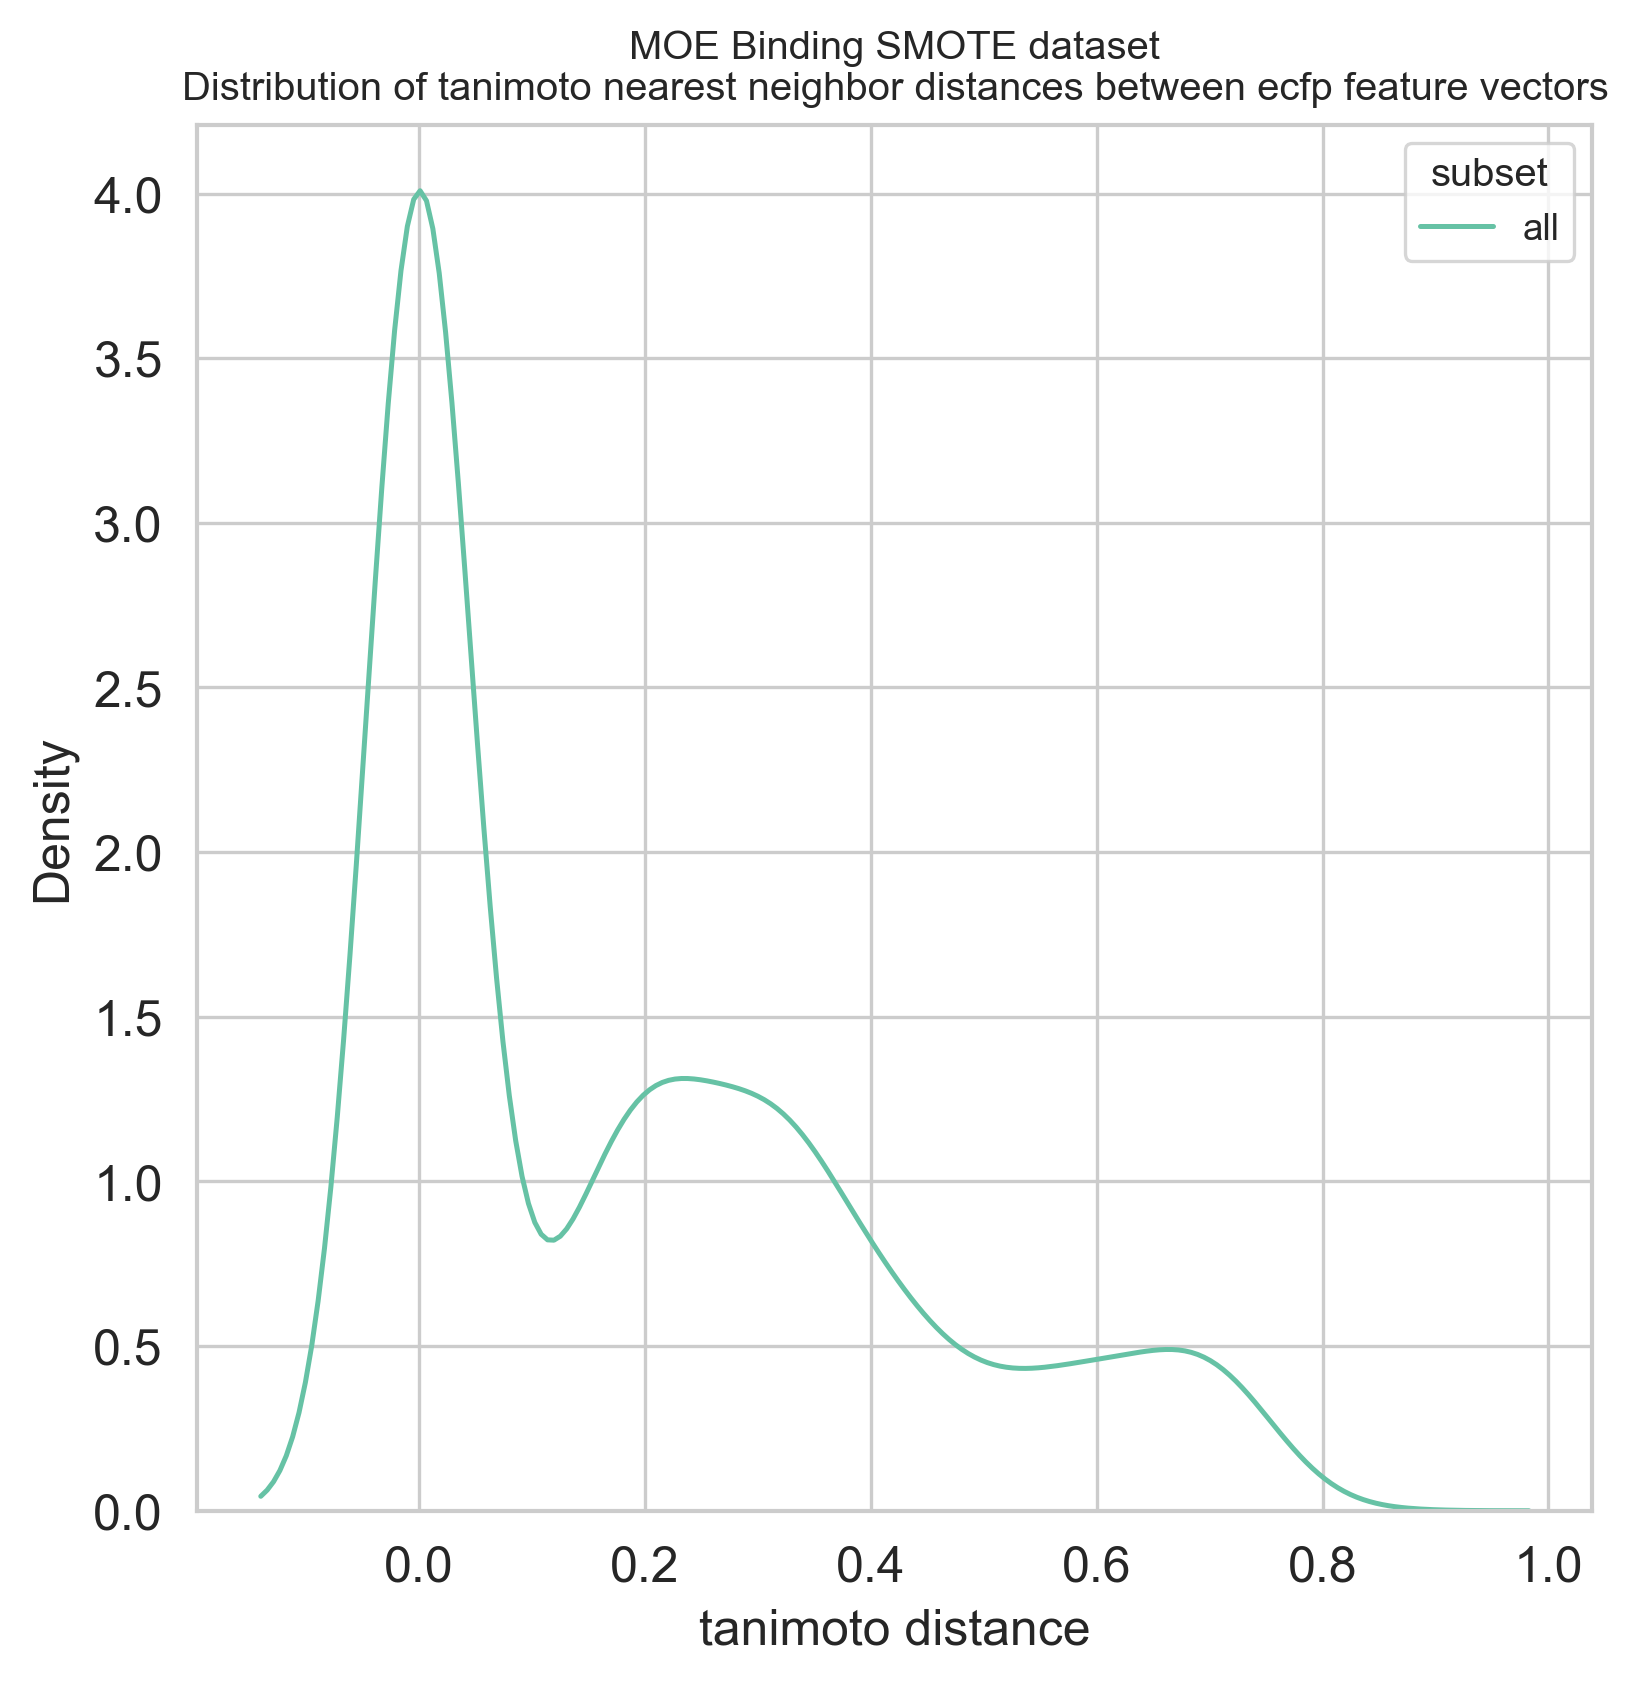

In [18]:
dp.plot_tani_dist_distr(df_SMOTE, 'base_rdkit_smiles', 'MOE Binding SMOTE')

dist subset
0    0.492537   test
1    0.392857   test
2    0.305085   test
3    0.369565   test
4    0.215686   test
..        ...    ...
278  0.000000   test
279  0.454545   test
280  0.285714   test
281  0.540541   test
282  0.228571   test

[283 rows x 2 columns]

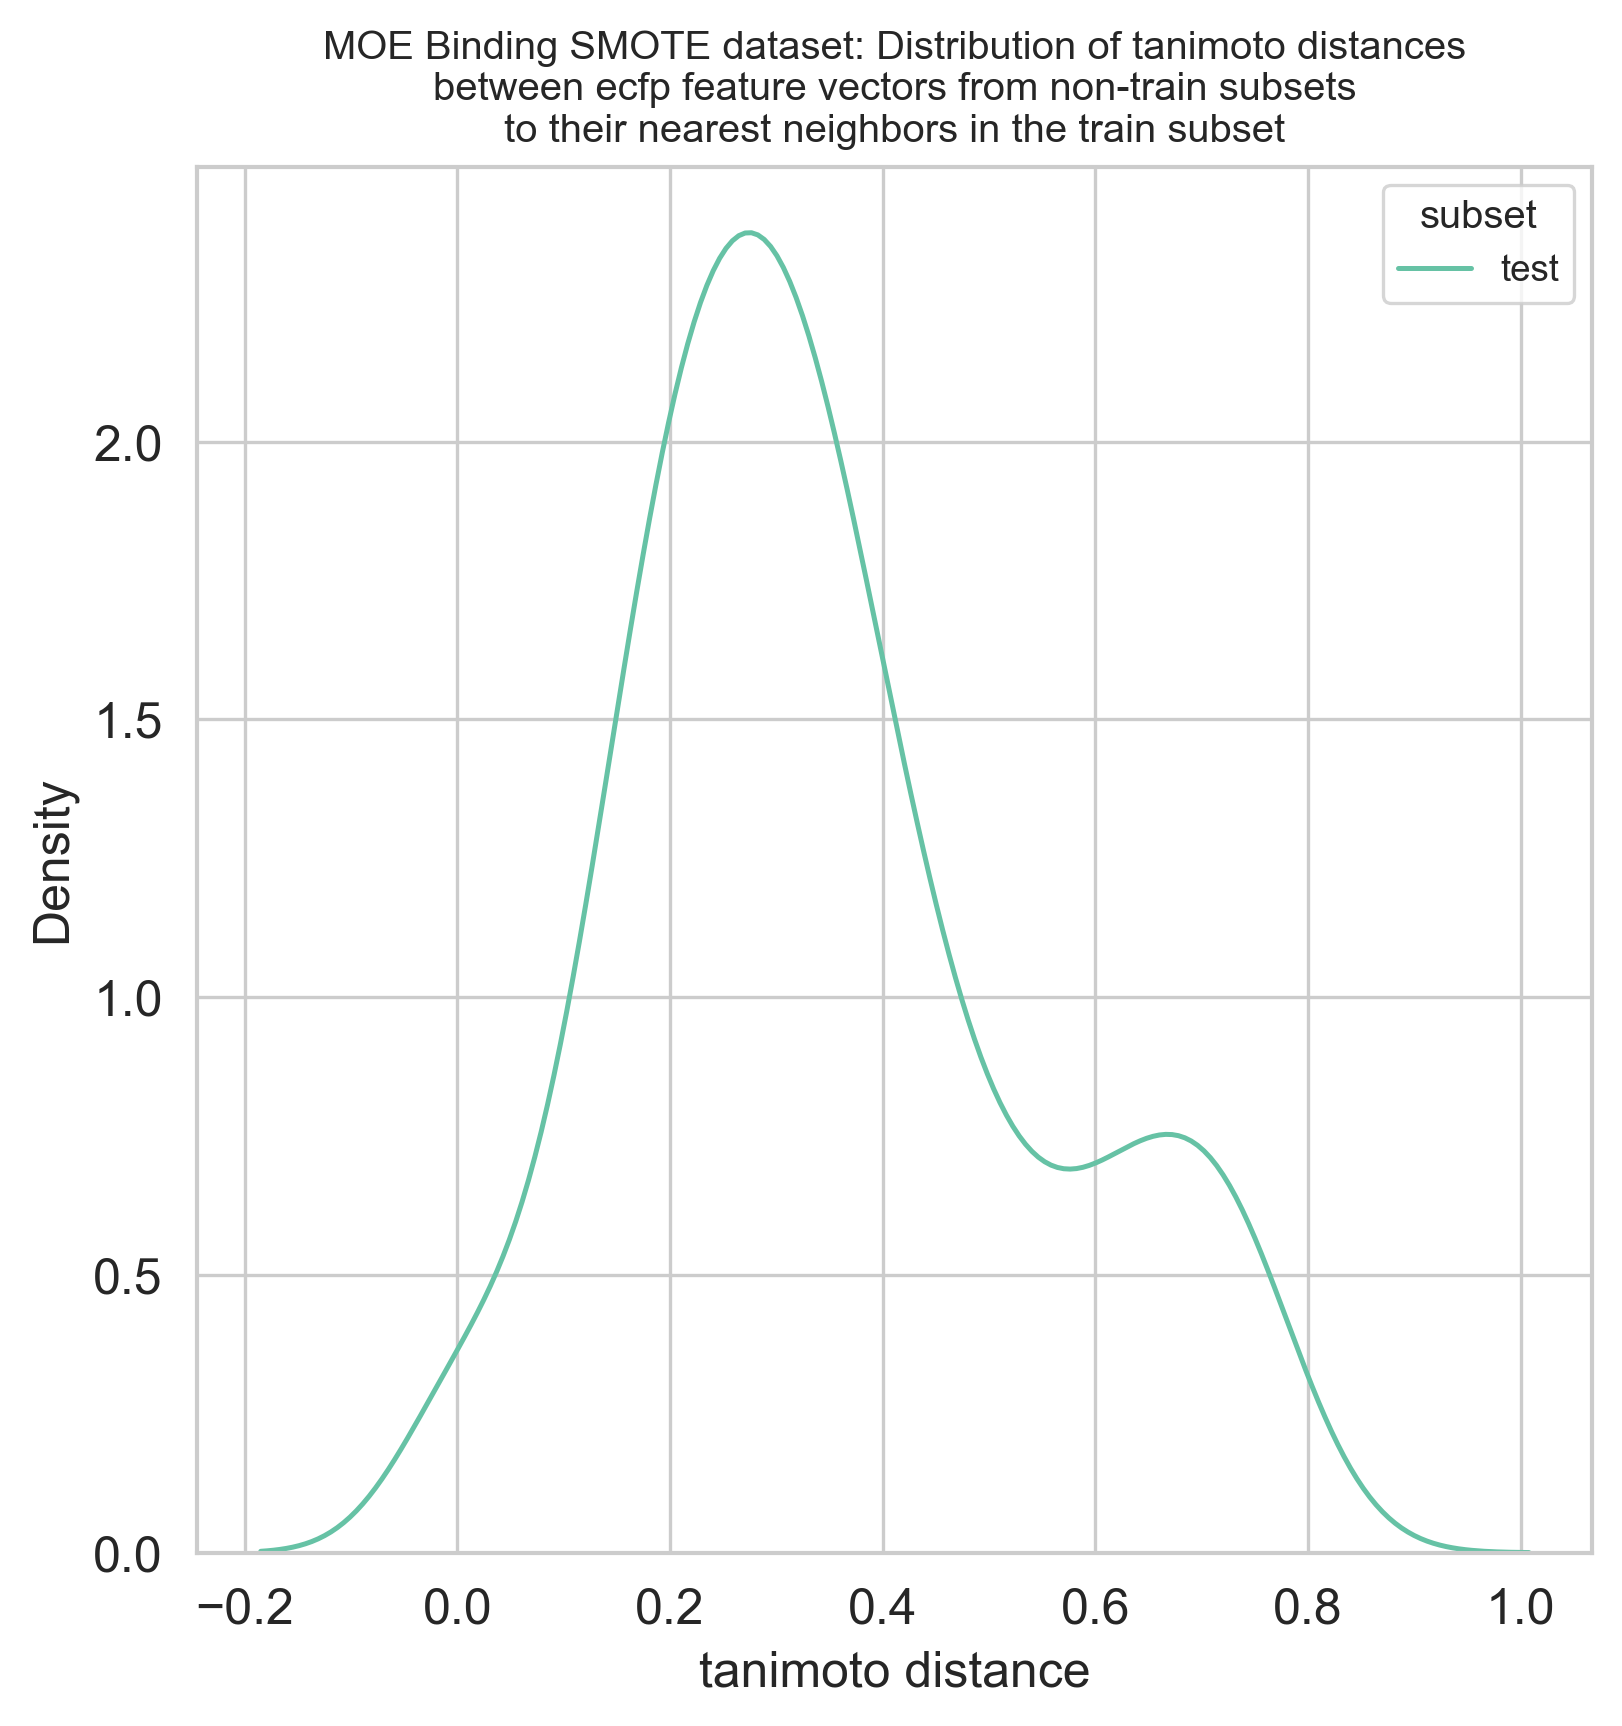

In [17]:
df_SMOTE = pd.read_csv('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/nek2/features/nek2_moe_bind_SMOTE.csv')
dp.plot_tani_dist_distr(df_SMOTE, 'base_rdkit_smiles', 'MOE Binding SMOTE', subset_col='subset',subsets=True)

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


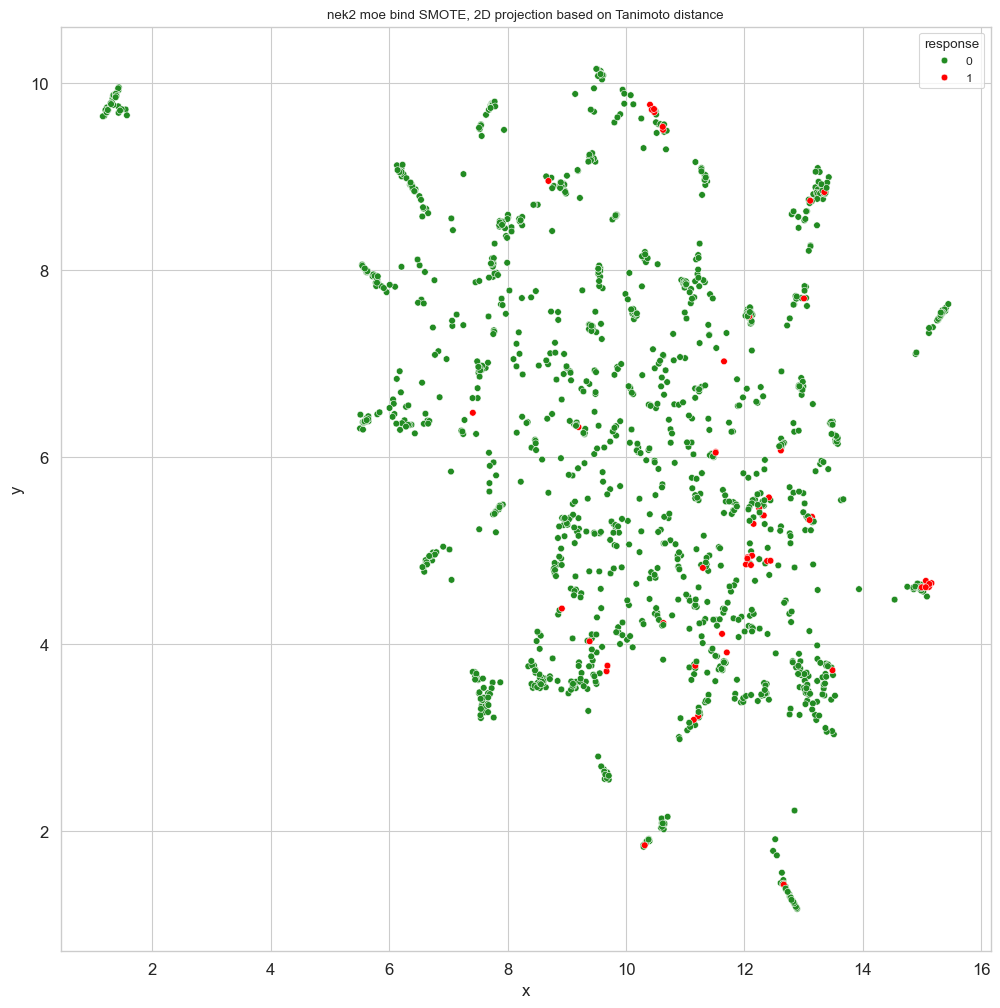

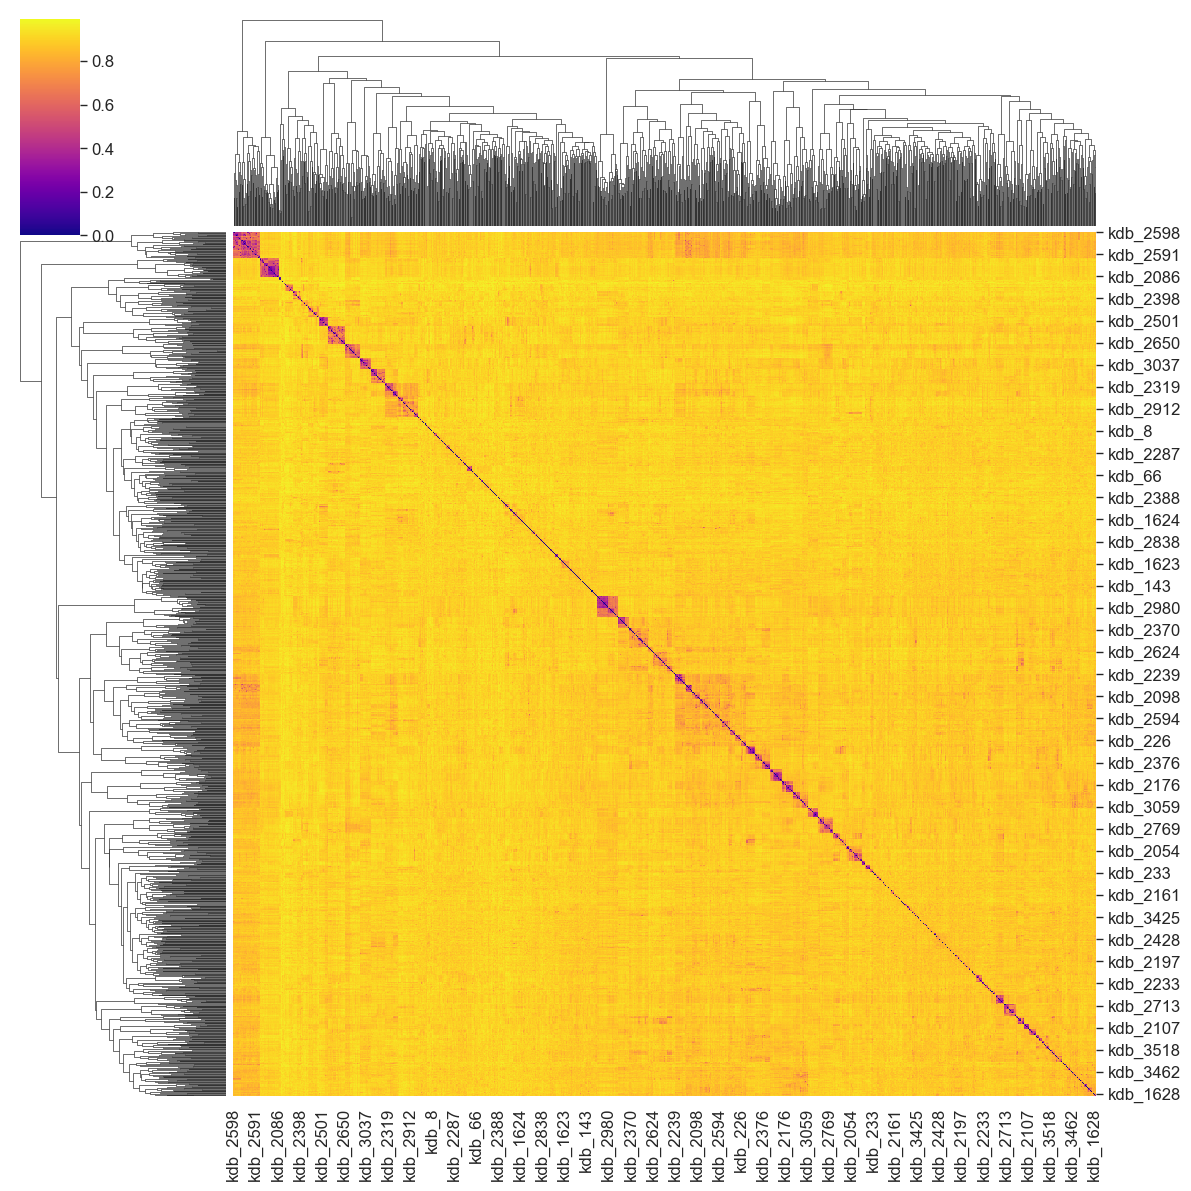

In [15]:
dp.diversity_plots(dset_key='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/nek2/features/nek2_moe_bind_SMOTE.csv',
                   datastore=False, 
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'active')


<p> I would model either pXC50 or pKI values. They are the most abundant in the dataset and commonly used for modeling. pKI is more normally distributed, but pXC50 values allow inclusion of excape data. 

According to some sources, these two datapoints can be combined in various ways, as well, but that's beyond the scope of this class.

I would choose a reasonable IC50 concentration to use as a threshold (perhaps 10uM, or consult with a scientist), and anything with an IC50 above that threshold is inactive (you need more drug to get activity) and IC50s below this threshold is active (you need less drug for activity, meaning the compound is MORE active per unit)

## EDA tips
- Make sure smiles strings exist since that's what AMPL uses
- Compare compounds in each dataset
- Featurize with ECFP fingerprints
- Examine diversity of compound set

## Discussion on the analysis of the heatmap and density plots
```
what are Morgan fingerprints (ecfp)? 
what does radius mean?
what does a bit in an ECFP vector correspond to?
what radius and vector length are used in these functions?
hint: look at the .py files for more info
```
ECFP fingerprints are a bit vector representation of a compound's structure. Each bit represents the presence or absence of a certain 'connectivity' between atoms in a molecule. The radius used in the diversity plots function is radius 4 and length 1024. The tanimoto plot function uses radius 2. Radius means number of atoms you travel away from the given atom to assess connectivity, allowing you to look at larger or smaller molecule fragments.


```
what is tanimoto distance? What do values closer to zero or closer to one mean?
Do you think your sets of compounds are diverse?
What do you observe from the 2D projection of compounds?
Are there any similarities between groups of compounds in your datasets?
```

Tanimoto similarity (or jaccard index) represents how well two bit vectors overlap. Thus, distance represents how 'far' away they are from perfect overlap. A distance closer 1 means the fingerprints (and therefore molecules) are less similar to each other. A distance closer to zero means molecules are more similar. 

Compounds that are shown in this exercise have average tanimoto distances ~ 0.85 - 0.9, so they are fairly diverse.

In the ChEMBL dataset, the 2D project separates high and low pChEMBL values very well. The DTC and Excape datasets don't separate as well, but DTC also is on a very different scale.

From the heatmap, we can see clusters/squares of compounds with tanimoto distance closer to zero (purple) so I suspect there are some groups of compounds that are very similar.


# EDA: Curated data
- First let us curate the data
- Examine new compound overlaps
- Examine final response column distributions
- Filter for 
  - large compounds
  - too high / too low pXC50 values
- double check for no NA values left
- save final curated dataset for further processing

Start here if you want to restart from here. Dont forget to uncomment the following code chunk

In [102]:
# chembl=pd.read_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_ChEMBL_SMILES_std.csv", index_col=0)
# dtc=pd.read_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_DTC_SMILES_std.csv", index_col=0)
# excape=pd.read_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_Excape_SMILES_std.csv", index_col=0)

In [121]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoDistMat

import umap
from scipy.stats.kde import gaussian_kde
from scipy.cluster.hierarchy import linkage


2021-09-17 21:50:35,143 *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


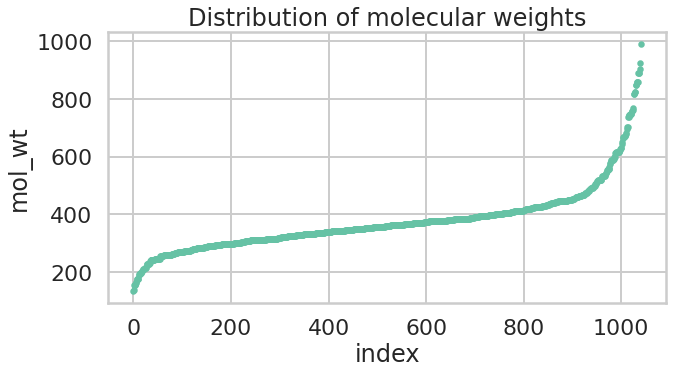

In [122]:
HTR3A_cur["mol_wt"] = [Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smile)) for smile in HTR3A_cur["base_rdkit_smiles"]]
HTR3A_cur = HTR3A_cur.sort_values('mol_wt')
HTR3A_cur=HTR3A_cur.reset_index(drop=True)
HTR3A_cur=HTR3A_cur.reset_index() # plot x axis as index #'s
fig,ax=plt.subplots(figsize=(10,5))
HTR3A_cur.plot(kind='scatter', x='index', y='mol_wt', ax=ax);
plt.title("Distribution of molecular weights");

In [123]:
print(HTR3A_cur.shape)
HTR3A_cur = HTR3A_cur[HTR3A_cur.mol_wt <1400]
print(HTR3A_cur.shape)

(1041, 7)
(1041, 7)


2021-09-17 21:50:35,636 *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


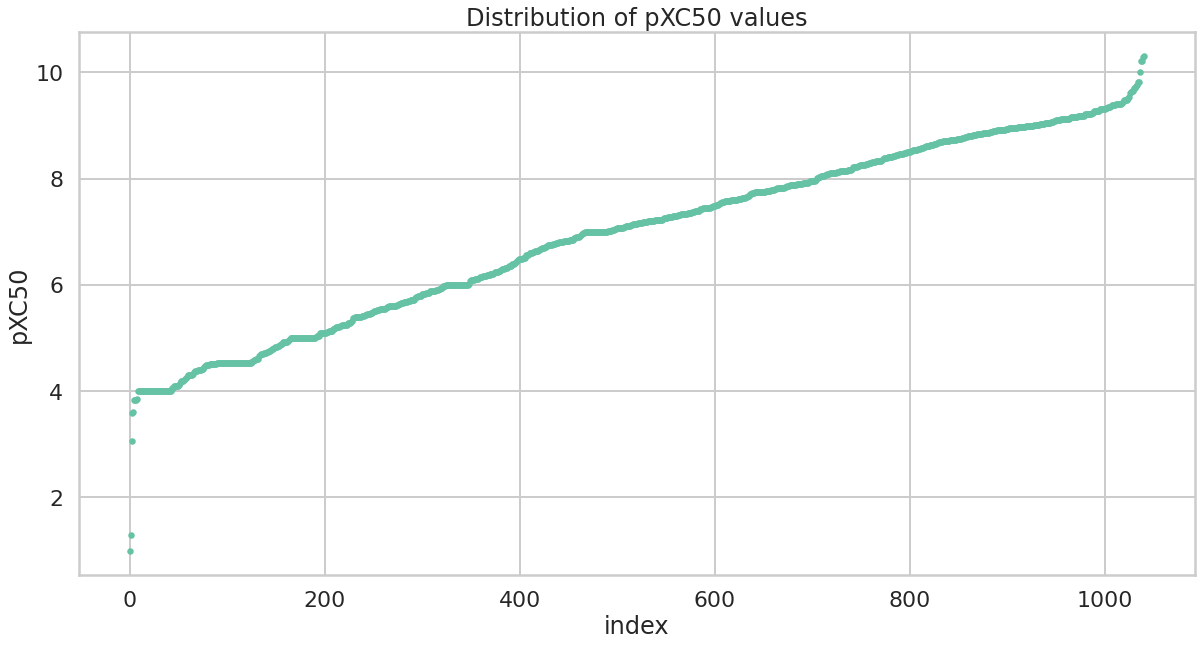

In [124]:
HTR3A_cur=HTR3A_cur.drop(columns=['index'])
HTR3A_cur = HTR3A_cur.sort_values('pXC50')
HTR3A_cur = HTR3A_cur.reset_index(drop=True)
HTR3A_cur = HTR3A_cur.reset_index() # plot x axis as index #'s
fig,ax=plt.subplots(figsize=(20,10))
HTR3A_cur.plot(kind='scatter', x='index', y='pXC50', ax=ax);
plt.title("Distribution of pXC50 values");

In [125]:
print(HTR3A_cur.shape)
HTR3A_cur=HTR3A_cur[HTR3A_cur.pXC50>2]
HTR3A_cur=HTR3A_cur[HTR3A_cur.pXC50<14]
print(HTR3A_cur.shape)

(1041, 7)
(1039, 7)


In [126]:
for col in HTR3A_cur.columns:
  print(col, HTR3A_cur[col].isna().values.any())

index False
compound_id True
base_rdkit_smiles False
relation False
pXC50 False
active False
mol_wt False


array([0.94444444, 0.88888889, 0.94642857, ..., 0.83950617, 0.83950617,
       0.85294118])

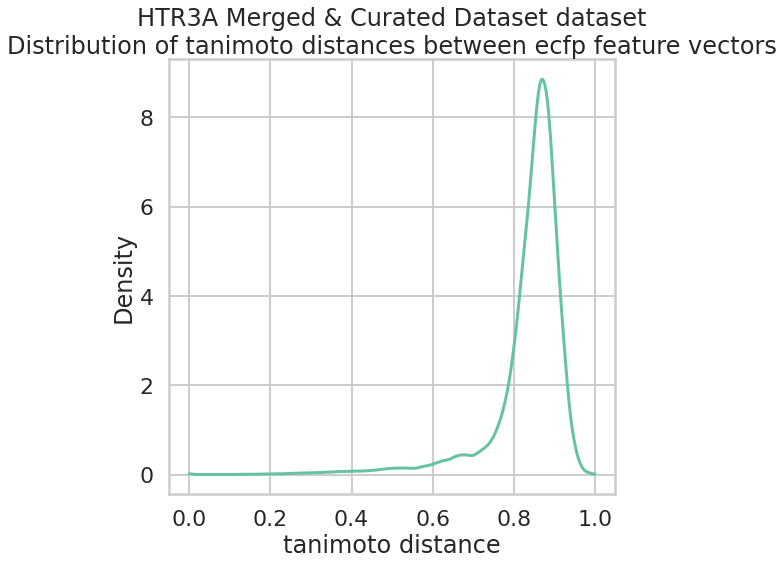

In [127]:
dp.plot_tani_dist_distr(HTR3A_cur, 'base_rdkit_smiles', 'HTR3A Merged & Curated Dataset')

In [128]:
HTR3A_cur.to_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_cur.csv")

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


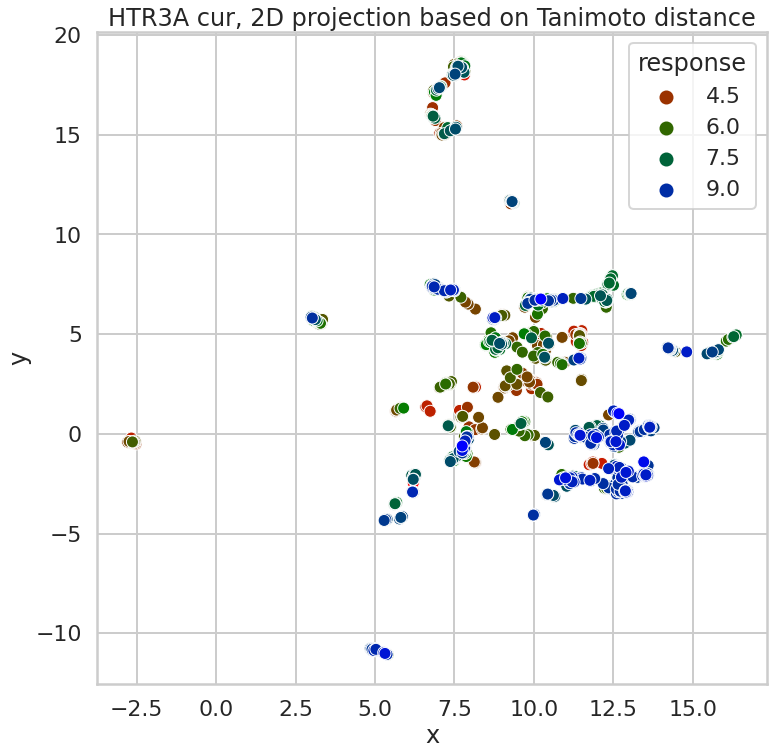

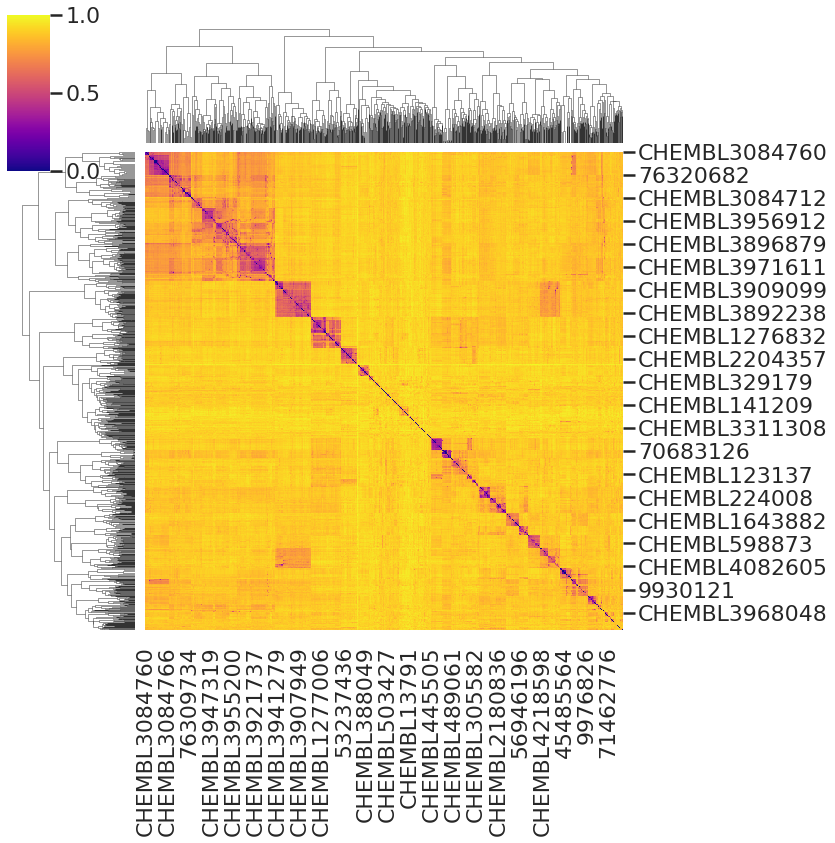

In [129]:
dp.diversity_plots('/content/drive/MyDrive/AMPL_EDA_07/HTR3A_cur.csv', 
                   datastore = False,
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


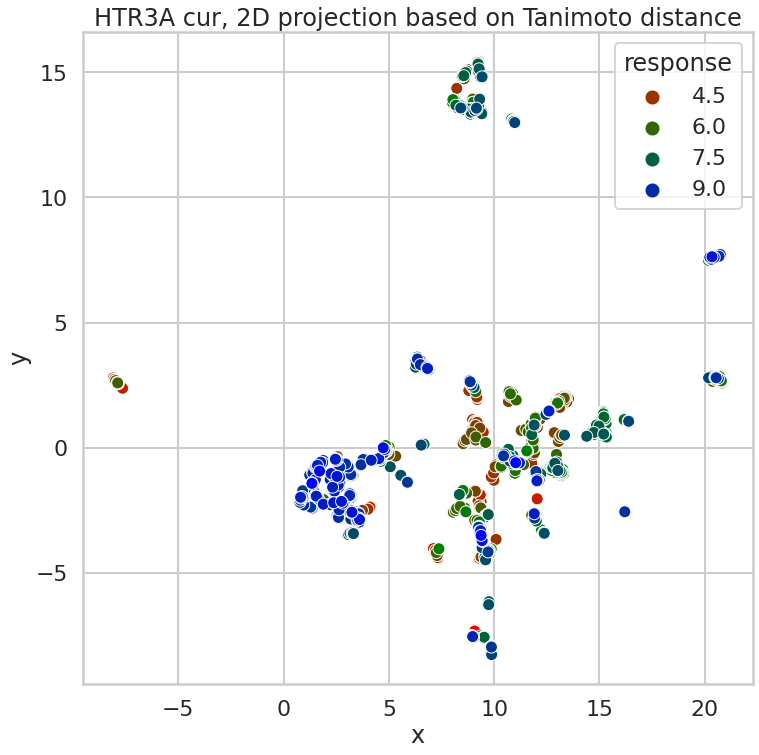

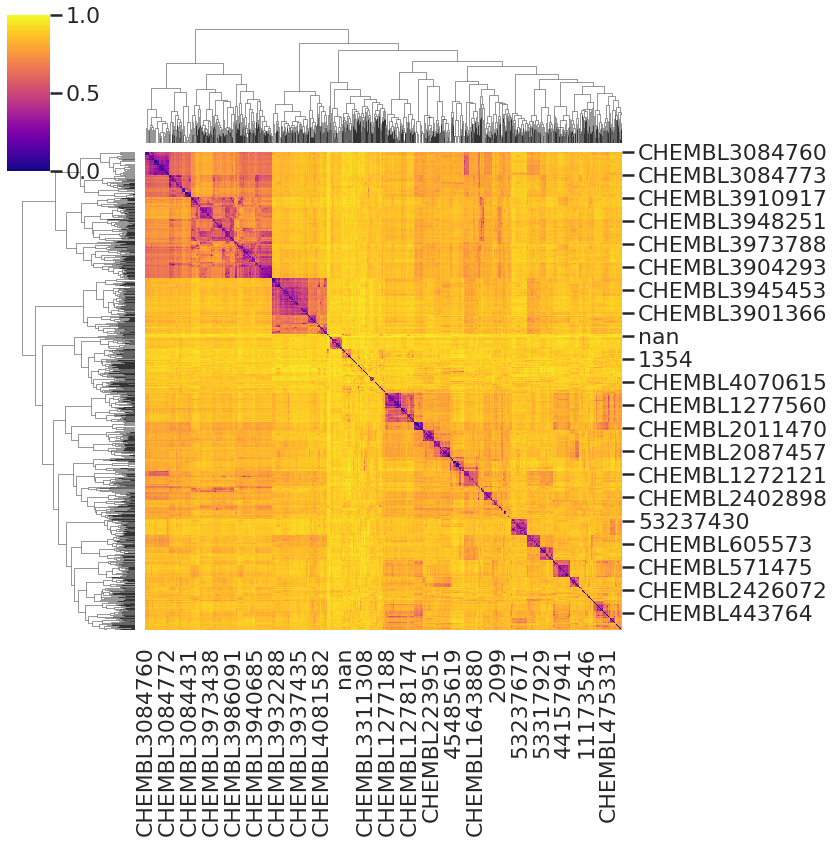

In [130]:
dp.diversity_plots('/content/drive/MyDrive/AMPL_EDA_07/HTR3A_cur.csv', 
                   datastore = False,
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50',
                   ecfp_radius = 2)

# Now you're ready to move on to the next stage of EDA & modeling: featurizing datasets
- featurize with structure-based fingerprints like ECFP
- or molecular descriptor sets like RDKit and Mordred
- these are high - dimensional datasets (200-2000 features or 'dimensions')
- so UMAP, tSNE and other dimensionality reduction techniques will help visualize the 'chemical space' of the dataset